In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import warnings

import pandas as pd
import scipy.cluster.hierarchy as spc

import matplotlib.pyplot as plt 
import seaborn as sns
import sys

In [8]:
warnings.filterwarnings('ignore')

In [9]:
input_path = "/home/gjhuh/covid_19/Korea_Prep/Data/"
file_date = "201231"
out_path = "/home/gjhuh/covid_19/Korea_Prep/Plot/"

Jurisdiction
Date
C1_School_closing
C2_Workplace_closing
C3_Cancel_public_events
C4_Restrictions_on_gatherings
C5_Close_public_transport
C6_Stay_at_home_requirements
C7_Restrictions_on_internal_movement
C8_International_travel_controls
E1_Income_support
E2_Debt_contract_relief
H1_Public_information_campaigns
H2_Testing_policy
H3_Contact_tracing
H6_Facial_Coverings
StringencyIndex
['C1_School_closing', 'C2_Workplace_closing', 'C3_Cancel_public_events', 'C4_Restrictions_on_gatherings', 'C6_Stay_at_home_requirements', 'C7_Restrictions_on_internal_movement', 'C8_International_travel_controls']


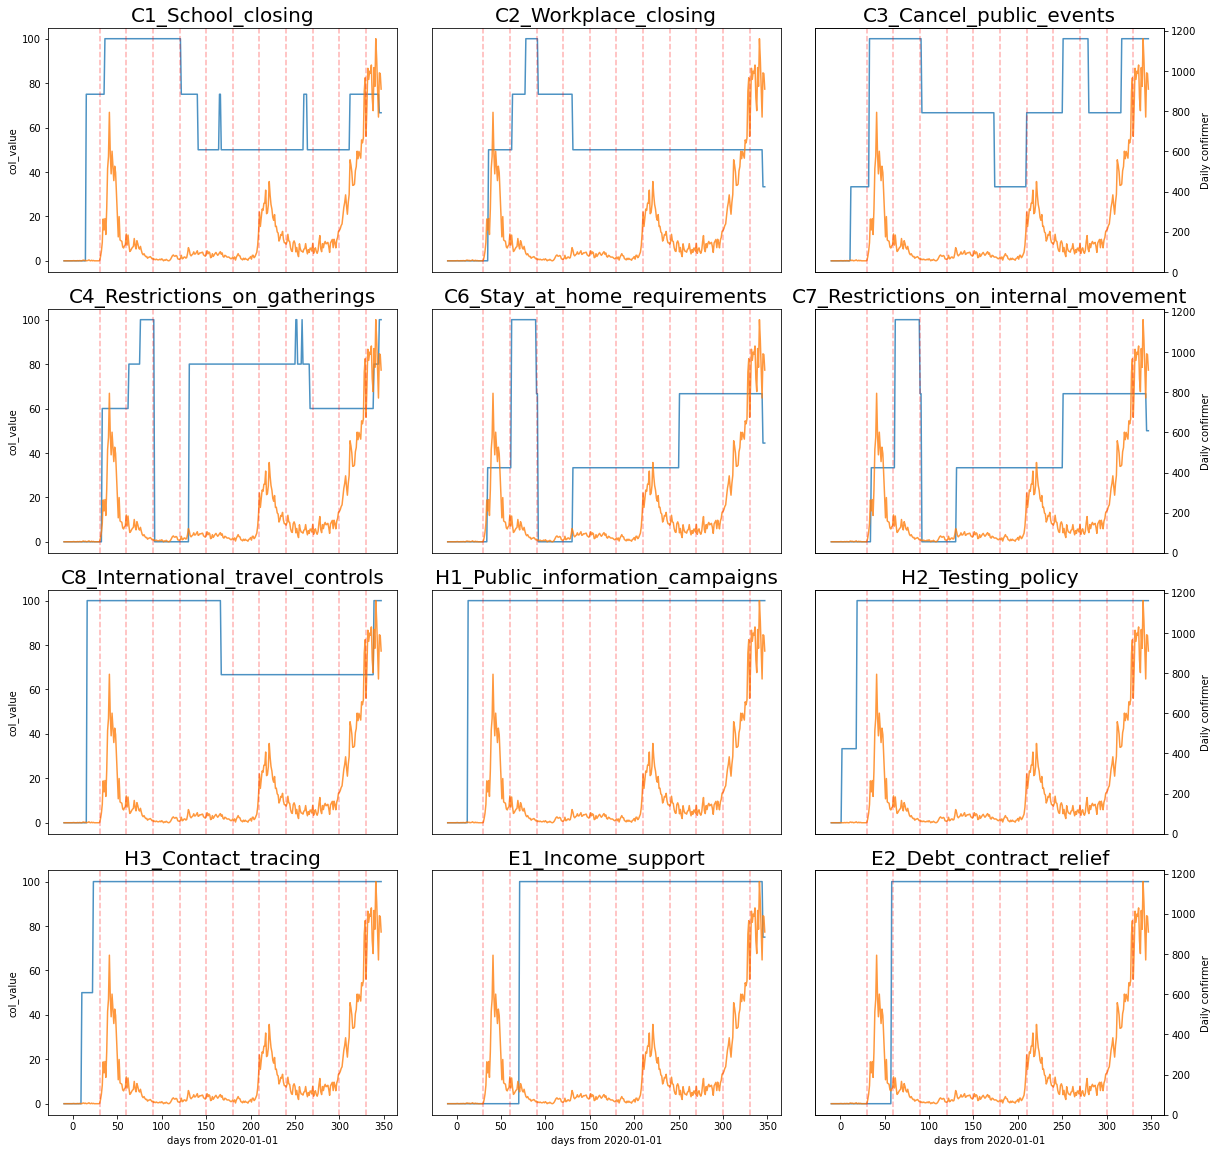

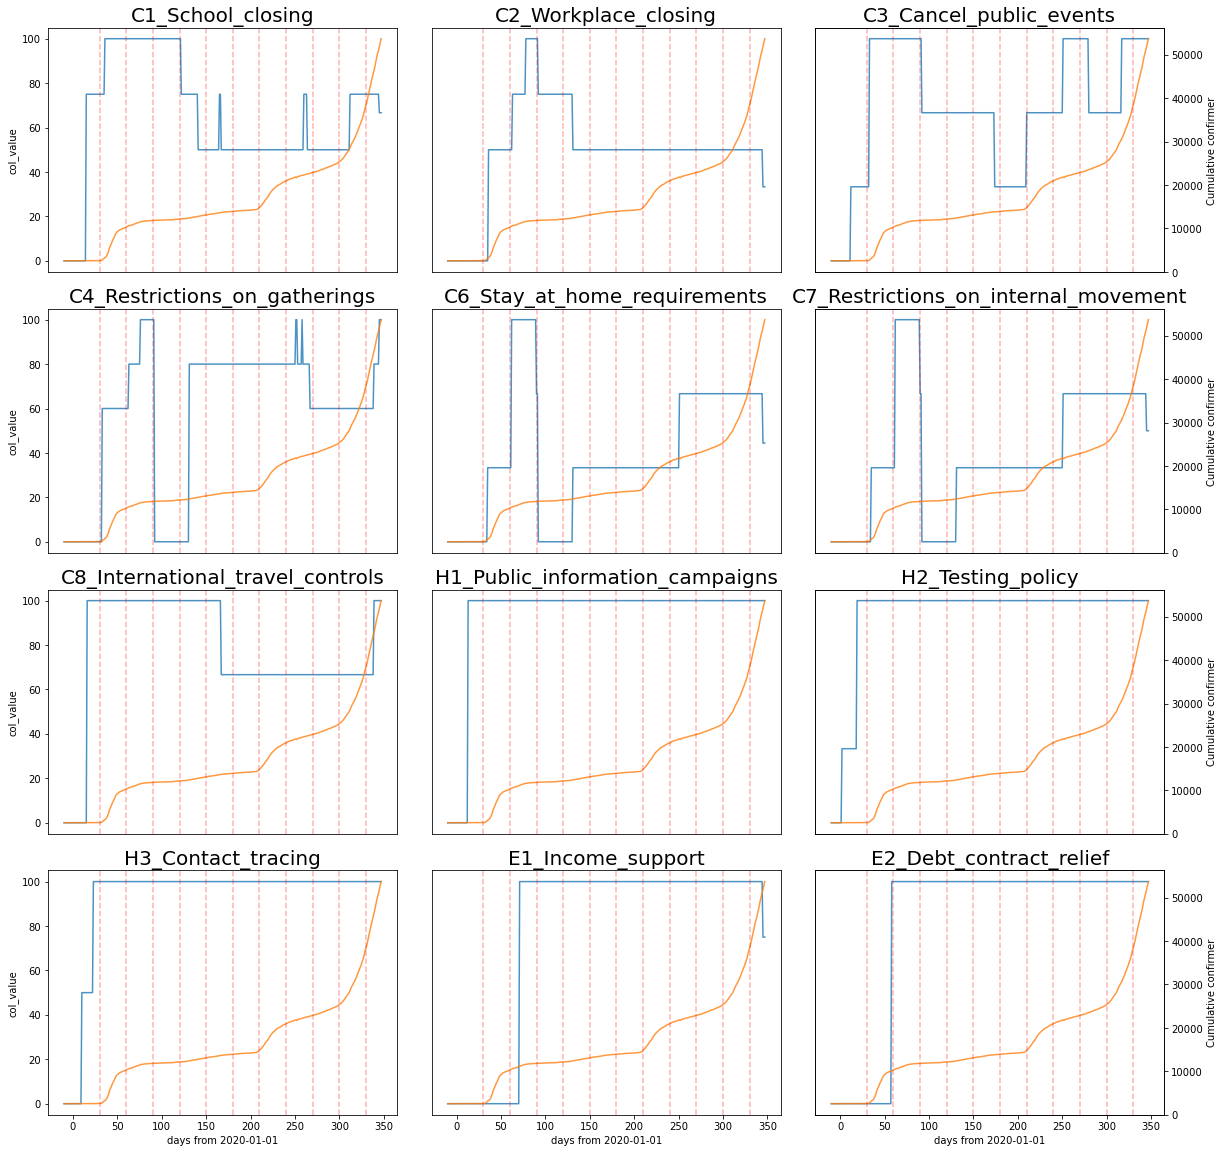

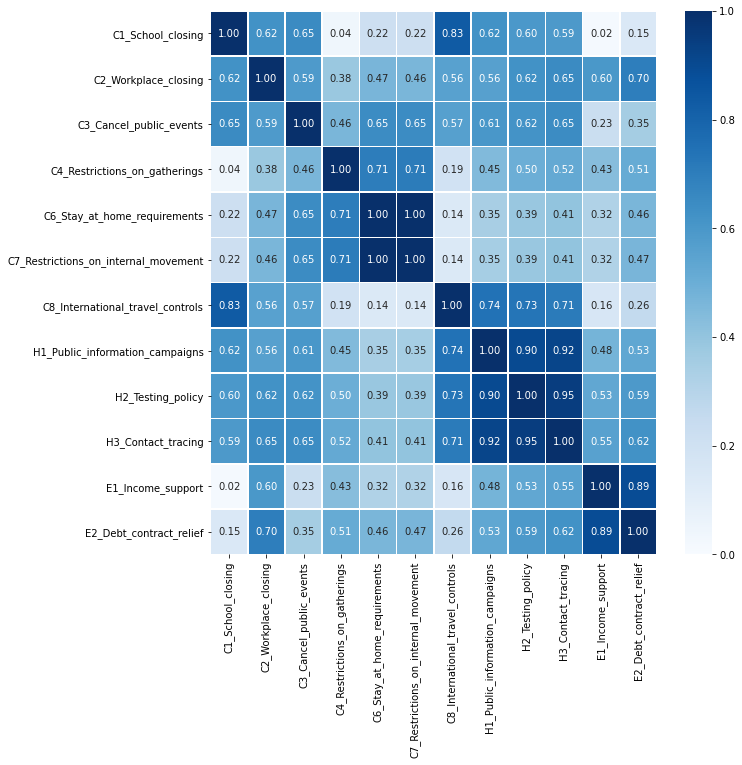

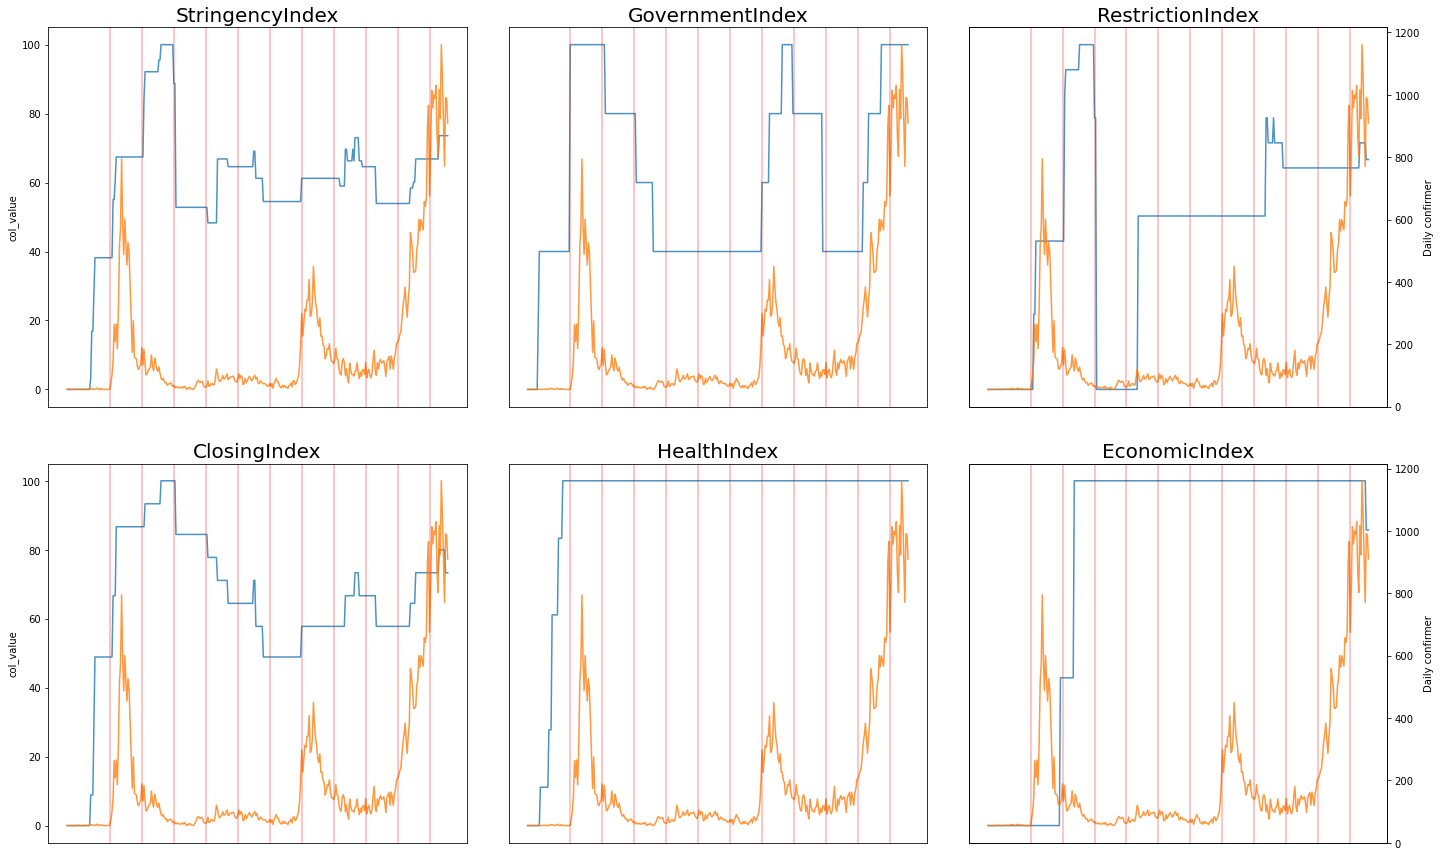

In [10]:
input_data_1 = input_path+'KOR_additive_measure_'+file_date+'.csv'
output_data_1 = input_path+'KOR_additive_measure_'+file_date+'_with_policy.csv'
oxford_data = input_path+'OxCGRT_latest_'+file_date+'.csv'
output_file = input_path+'KOR_additive_measure_cluster_'+file_date+'.csv'

data = pd.read_csv(input_data_1, index_col=0)
data = data.reset_index(drop=True)
policy_columns = ['CountryCode', 'RegionName', 'RegionCode', 'Date', 'C1_School_closing',
       'C2_Workplace_closing', 'C3_Cancel_public_events',
       'C4_Restrictions_on_gatherings', 'C5_Close_public_transport',
       'C6_Stay_at_home_requirements', 'C7_Restrictions_on_internal_movement',
       'C8_International_travel_controls', 'E1_Income_support',
       'E2_Debt_contract_relief', 'E3_Fiscal_measures',
       'E4_International_support', 'H1_Public_information_campaigns',
       'H2_Testing_policy', 'H3_Contact_tracing',
       'H4_Emergency_investment_in_healthcare', 'H5_Investment_in_vaccines',
       'ConfirmedCases', 'StringencyIndex', 'DailyConfirmed', 'Days',
       'GovernmentResponseIndex', 'ContainmentHealthIndex', 'EconomicSupportIndex',
       'smoothedDailyConfirm', 'Days_China']
first_date = data.Date[0]
oxford = pd.read_csv(oxford_data)
kor = oxford[oxford['CountryCode'] == 'KOR']
kor = kor[kor['Date']< int(first_date.replace('-',''))].iloc[-10:]
oxford_columns = list(kor.columns)
for i, column in enumerate(oxford_columns) : 
    oxford_columns[i] = column.replace(' ', '_')
    
kor.Date = pd.to_datetime(kor.Date,format='%Y%m%d')
data.Date = pd.to_datetime(data.Date, format='%Y-%m-%d')

kor.columns = oxford_columns
sub_table = pd.concat([kor , data])
new_table = sub_table.reset_index(drop=True)
new_table.loc[:len(kor.Date)-1,'Days'] = list(range(0-len(kor.Date), 0, 1))
new_table.loc[:len(kor.Date)-1,'DailyConfirmed'] = 0 

new_table.loc[:len(kor.Date)-1,['Domestic_ConfirmedCases', 'Domestic_DailyConfirmed', 'Capital_ConfirmedCases', 'Capital_DailyConfirmed', 'NonCapital_ConfirmedCases', 'NonCapital_DailyConfirmed' ]] = 0  

new_table = new_table.loc[:,data.columns]
new_table.to_csv(output_data_1)




policy_df = pd.read_csv(output_data_1, index_col=0)
policy_df = policy_df.iloc[:, 1:]

descriptive_policy = pd.DataFrame()
policy_df = policy_df.fillna(0)

for i, col_name in enumerate(policy_df.iloc[:,:-8].columns) : 
    policy = pd.DataFrame(policy_df[col_name].describe())
    descriptive_policy = pd.concat([descriptive_policy, policy], axis=1)

for column_name in descriptive_policy.columns: 
    print(column_name)
column_names = list(descriptive_policy.columns)

data = policy_df.iloc[:,[2,3,4,5,7,8,9]]

corr_data = data.corr()
dist_table = 1 - corr_data

pdist = dist_table.values 

linkage = spc.linkage(pdist)
idx = spc.fcluster(linkage, 1* pdist.max(), 'distance' )
# dn = spc.dendrogram(linkage, labels=dist_table.index,leaf_rotation=270, )
# plt.show()

corr_table  = data.corr()
corr_table.loc[:,'cluster'] = idx
clustered = []
for i in set(idx) :
    print(list(corr_table[corr_table['cluster'] == i ].index))
    clustered = clustered + list(corr_table[corr_table['cluster'] == i ].index)
    
clustered = clustered + ['H1_Public_information_campaigns', 'H2_Testing_policy', 'H3_Contact_tracing','E1_Income_support', 'E2_Debt_contract_relief']

data = policy_df.loc[:,column_names + ['Domestic_DailyConfirmed']]
clustered_with_daily = clustered +['Domestic_DailyConfirmed']
without_lagging = pd.DataFrame(data.corr().loc[clustered_with_daily,'Domestic_DailyConfirmed'])

# fig = plt.figure(figsize=(20,20))
nrow = 4
ncol = 3
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20,20))
fig.subplots_adjust(hspace=0.15, wspace=0.1)

for i, col_name in enumerate(clustered) : 
    row,col = [(i)//3, i%3]
    x = policy_df.loc[:,'Days']
    y = policy_df.loc[:,col_name]
    axes[row, col].set(xlabel='days from 2020-01-01', ylabel='col_value')
    axes[row, col].set_title(col_name, size=20)
    axes[row, col].plot(x, y/max(y)*100, '-', alpha = 0.8) 
    y = policy_df.loc[:,'Domestic_DailyConfirmed']
    axes[row, col].plot(x, y/max(y)*100, '-', alpha = 0.8) 

    count = 30  
    if col != 0 :
        axes[row, col].yaxis.set_visible(False)
    if col == 2 :
        ax2 = axes[row, col].twinx()
        ax2.set_ylabel("Daily confirmer")
        ax2.set_ylim(min(y), max(y)) 
    
    if row != 3 :
        axes[row,col].xaxis.set_visible(False) 
    
    while count < max(x) :  
        axes[row, col].axvline(count , linestyle='--', color='red', alpha=0.3)
        count += 30
plt.savefig(out_path+'policy_speared.png', dpi=300)

# fig = plt.figure(figsize=(20,20))
nrow = 4
ncol = 3
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20,20))
fig.subplots_adjust(hspace=0.15, wspace=0.1)

for i, col_name in enumerate(clustered) : 
    row,col = [(i)//3, i%3]
    x = policy_df.loc[:,'Days']
    y = policy_df.loc[:,col_name]
    axes[row, col].set(xlabel='days from 2020-01-01', ylabel='col_value')
    axes[row, col].set_title(col_name, size=20)
    axes[row, col].plot(x, y/max(y)*100, '-', alpha = 0.8) 
    y = policy_df.loc[:,'Domestic_ConfirmedCases']
    axes[row, col].plot(x, y/max(y)*100, '-', alpha = 0.8) 

    count = 30  
    if col != 0 :
        axes[row, col].yaxis.set_visible(False)
    if col == 2 :
        ax2 = axes[row, col].twinx()
        ax2.set_ylabel("Cumulative confirmer")
        ax2.set_ylim(min(y), max(y)) 
    
    if row != 3 :
        axes[row,col].xaxis.set_visible(False) 
    
    while count < max(x) :  
        axes[row, col].axvline(count , linestyle='--', color='red', alpha=0.3)
        count += 30
plt.savefig(out_path+'policy_speared_daily.png', dpi=300)


plt.figure(figsize=(10,10))
sns.heatmap(data = (policy_df.corr()).loc[clustered,clustered], annot=True, fmt = '.2f', linewidth=.5, cmap='Blues', vmin=0, vmax=1 )
plt.savefig(out_path+'policy_heatmap.png', dpi=300)

cluster_dict = {}
cluster_dict[1] = ['C4_Restrictions_on_gatherings', 'C6_Stay_at_home_requirements', 'C7_Restrictions_on_internal_movement']
cluster_dict[2] = ['C1_School_closing', 'C8_International_travel_controls' ,'C2_Workplace_closing', 'C3_Cancel_public_events']
cluster_dict[3] = ['H1_Public_information_campaigns', 'H2_Testing_policy', 'H3_Contact_tracing']
cluster_dict[4] = ['E1_Income_support','E2_Debt_contract_relief' ]

summary_idx = policy_df[['StringencyIndex', 'Government','Days', 'Domestic_DailyConfirmed', 'Domestic_ConfirmedCases']]
for i in range(1,5):
    policy_df['cluster'+str(i)+'_mean']= policy_df[cluster_dict[i]].mean(axis=1)
    
policy_df.columns = list(policy_df.columns[:-5]) + ['GovernmentIndex', 'RestrictionIndex', 'ClosingIndex', 'HealthIndex','EconomicIndex']
policy_df.to_csv(output_file)

# fig = plt.figure(figsize=(20,20))
nrow = 2
ncol = 3
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(24,15))
fig.subplots_adjust(hspace=0.15, wspace=0.1)
indexes = ['StringencyIndex'] +  ['GovernmentIndex', 'RestrictionIndex', 'ClosingIndex', 'HealthIndex','EconomicIndex']
for i, col_name in enumerate(indexes) : 
    row,col = [(i)//3, i%3]
#     print(row,col)
    x = policy_df.loc[:,'Days']
    y = policy_df.loc[:,col_name]
    axes[row, col].set(xlabel='days from 2020-01-01', ylabel='col_value')
    axes[row, col].set_title(col_name, size=20)
    axes[row,col].plot(x, y/max(y)*100, '-', alpha = 0.8) 
    y = policy_df.loc[:,'Domestic_DailyConfirmed']
    axes[row, col].plot(x, y/max(y)*100, '-', alpha = 0.8) 
#     print(row,col)아
    count = 30  
    if col != 0 :
        axes[row, col].yaxis.set_visible(False)
    if col == 2 :
        ax2 = axes[row, col].twinx()
        ax2.set_ylabel("Daily confirmer")
        ax2.set_ylim(min(y), max(y)) 
    
    if row != 2 :
        axes[row,col].xaxis.set_visible(False) 
    
    while count < max(x) :  
        axes[row, col].axvline(count , linestyle='-', color='red', alpha=0.3)
        count += 30
plt.savefig(out_path+'index_spread.png', dpi=300)